In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
import random
import re
import glob
from skimage import io
from skimage import transform
from PIL import Image

In [ ]:
!pip install -U pydicom
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install utils
!pip install scikit-image
!pip install pillow

     |████████████████████████████████| 7.1MB 2.6MB/s 
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-k9it7pnc
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-k9it7pnc
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=4208636253dd61428119f01786dec6c918068424c49d66aa4cce2d4867113caf
  Stored in directory: /tmp/pip-ephem-wheel-cache-by54pq3g/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
        )
        
val_datagen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [ ]:
train_image_generator = train_datagen.flow_from_directory(
'/content/drive/My Drive/data/mri/train_frames/',
class_mode=None,
color_mode="grayscale",
batch_size = 2 )

train_mask_generator = train_datagen.flow_from_directory(
'/content/drive/My Drive/data/mri/train_masks/',
class_mode=None,
color_mode="grayscale",
batch_size = 2 )

val_image_generator = val_datagen.flow_from_directory(
'/content/drive/My Drive/data/mri/val_frames/',
class_mode=None,
color_mode="grayscale",
batch_size = 2 )


val_mask_generator = val_datagen.flow_from_directory(
'/content/drive/My Drive/data/mri/val_masks/',
class_mode=None,
color_mode="grayscale",
batch_size = 2 )

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.
Found 12 images belonging to 1 classes.
Found 12 images belonging to 1 classes.


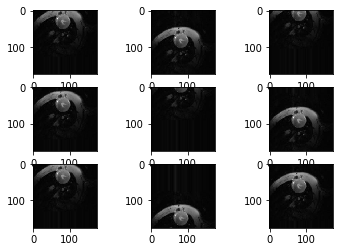

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
img = load_img('/content/drive/My Drive/data/mri/train_frames/train/10cineSax_00010.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rescale=1./255, height_shift_range=0.5)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0]
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [ ]:
def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"%d.jpg"%i),as_gray = as_gray)
        img = img / 255
        img = transform.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.jpg"%i),img)

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/data')
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import model

NO_OF_TRAINING_IMAGES = len(os.listdir('/content/drive/My Drive/data/mri/train_frames/train/'))
NO_OF_VAL_IMAGES = len(os.listdir('/content/drive/My Drive/data/mri/val_frames/val/'))

NO_OF_EPOCHS = 30
BATCH_SIZE = 2
weights_path = '/content/drive/My Drive/data/mri/'

m = model.unet()
opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

m.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(weights_path, monitor='METRIC_TO_MONITOR', 
                             verbose=1, save_best_only=True, mode='max')

csv_logger = CSVLogger('./log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor = 'METRIC_TO_MONITOR', verbose = 1,
                              min_delta = 0.01, patience = 3, mode = 'max')

callbacks_list = [checkpoint, csv_logger, earlystopping]

hist = m.fit_generator(train_generator, epochs=NO_OF_EPOCHS, 
                          steps_per_epoch = (NO_OF_TRAINING_IMAGES//BATCH_SIZE),
                          validation_data=val_generator, 
                          validation_steps=(NO_OF_VAL_IMAGES//BATCH_SIZE), 
                          callbacks=callbacks_list)
m.save('Model.h5')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/content/drive/My Drive/data/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)





Epoch 1/30





21/21 [==============================] - 47s 2s/step - loss: 0.4524 - acc: 0.8684 - val_loss: 0.3682 - val_acc: 0.9518
Epoch 2/30
 2/21 [=>............................] - ETA: 1s - loss: 0.3787 - acc: 0.9389

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with METRIC_TO_MONITOR available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `METRIC_TO_MONITOR` which is not available. Available metrics are: val_loss,val_acc,loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


21/21 [==============================] - 2s 110ms/step - loss: 0.3293 - acc: 0.9415 - val_loss: 0.3297 - val_acc: 0.9519
Epoch 3/30
21/21 [==============================] - 2s 111ms/step - loss: 0.2656 - acc: 0.9426 - val_loss: 0.3162 - val_acc: 0.9524
Epoch 4/30
21/21 [==============================] - 2s 111ms/step - loss: 0.1888 - acc: 0.9416 - val_loss: 0.2972 - val_acc: 0.9534
Epoch 5/30
21/21 [==============================] - 2s 111ms/step - loss: 0.1374 - acc: 0.9426 - val_loss: 0.2299 - val_acc: 0.9557
Epoch 6/30
21/21 [==============================] - 2s 110ms/step - loss: 0.1097 - acc: 0.9416 - val_loss: 0.1745 - val_acc: 0.9553
Epoch 7/30
21/21 [==============================] - 2s 110ms/step - loss: 0.0976 - acc: 0.9433 - val_loss: 0.2007 - val_acc: 0.9555
Epoch 8/30
21/21 [==============================] - 2s 111ms/step - loss: 0.0921 - acc: 0.9440 - val_loss: 0.1893 - val_acc: 0.9558
Epoch 9/30
21/21 [==============================] - 2s 111ms/step - loss: 0.0886 - acc:

Text(0, 0.5, 'Accuracy')

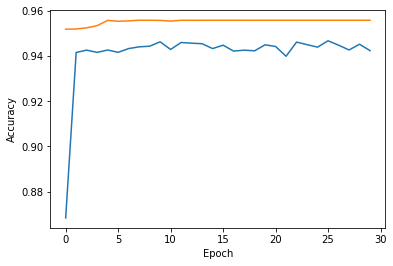

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
testGene = testGenerator("/content/drive/My Drive/data/mri/test/")
results = m.predict_generator(testGene,4,verbose=1)
saveResult("/content/drive/My Drive/data/mri/test/",results)

4/4 [==============================] - 2s 465ms/step
